In [1]:
import sys

In [2]:
available = [
    'Adventure',
    'AirRaid',
    'Alien',
    'Amidar',
    'Assault',
    'Asterix',
    'Asteroids',
    'Atlantis',
    'Atlantis2',
    'Backgammon',
    'BankHeist',
    'BasicMath',
    'BattleZone',
    'BeamRider',
    'Berzerk',
    'Blackjack',
    'Bowling',
    'Boxing',
    'Breakout',
    'CMakeLists',
    'Carnival',
    'Casino',
    'Centipede',
    'ChopperCommand',
    'CrazyClimber',
    'Crossbow',
    'DarkChambers',
    'Defender',
    'DemonAttack',
    'DonkeyKong',
    'DoubleDunk',
    'Earthworld',
    'ElevatorAction',
    'Enduro',
    'Entombed',
    'Et',
    'FishingDerby',
    'FlagCapture',
    'Freeway',
    'Frogger',
    'Frostbite',
    'Galaxian',
    'Gopher',
    'Gravitar',
    'Hangman',
    'HauntedHouse',
    'Hero',
    'HumanCannonball',
    'IceHockey',
    'JamesBond',
    'JourneyEscape',
    'Kaboom',
    'Kangaroo',
    'KeystoneKapers',
    'Kingkong',
    'Klax',
    'Koolaid',
    'Krull',
    'KungFuMaster',
    'LaserGates',
    'LostLuggage',
    'MarioBros',
    'MiniatureGolf',
    'MontezumaRevenge',
    'MrDo',
    'MsPacman',
    'NameThisGame',
    'Othello',
    'Pacman',
    'Phoenix',
    'Pitfall',
    'Pitfall2',
    'Pong',
    'Pooyan',
    'PrivateEye',
    'QBert',
    'RiverRaid',
    'RoadRunner',
    'RoboTank',
    'Seaquest',
    'SirLancelot',
    'Skiing',
    'Solaris',
    'SpaceInvaders',
    'SpaceWar',
    'StarGunner',
    'Superman',
    'Surround',
    'Tennis',
    'Tetris',
    'TicTacToe3d',
    'TimePilot',
    'Trondead',
    'Turmoil',
    'Tutankham',
    'UpNDown',
    'Venture',
    'VideoCheckers',
    'VideoChess',
    'VideoCube',
    'VideoPinball',
    'WizardOfWor',
    'WordZapper',
    'YarsRevenge',
    'Zaxxon'
 ]

In [3]:
available = [
    'Pong',
 ]

In [4]:
import gymnasium as gym

seed = 0
env_names = [
    f"ALE/{name}-v5"
    for name in available
]
envs = {}
i = 0
for name in env_names:
    try:
        envs[f'{name}_{i}'] = gym.make(name)
    except:
        try:
            envs[f'{name}_{i}'] = gym.make(name.capitalize())
        except:
            pass

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [5]:
len(envs)

1

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

In [7]:
input_shape = (210, 160, 3)
exclude_env = []
observation = None
for env_name, env in envs.items():
    observation, _ = env.reset(seed=seed)
    if observation.shape != input_shape:
        exclude_env.append(env_name)
        continue
    
for env_name in exclude_env:
    del envs[env_name]

In [8]:
len(envs)

1

In [9]:
all_names = f'Atari_85_games'

In [10]:
encoder_alpha = 0.4

In [11]:
weights_name = f"{all_names}_autoencoder_{encoder_alpha}.state_dict"
weights_name

'Atari_85_games_autoencoder_0.4.state_dict'

In [12]:
from skimage.transform import rescale, resize, downscale_local_mean

def resize_frame(frame):
    image_resized = downscale_local_mean(frame, (6, 4, 1))
    return image_resized.astype(int)
    
image_downscaled = resize_frame(observation)
input_shape = image_downscaled.shape
input_shape

(35, 40, 3)

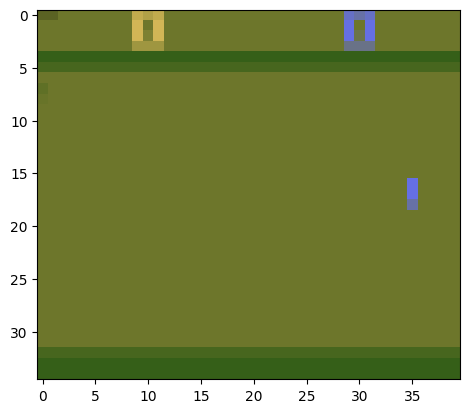

In [13]:
plt.imshow(image_downscaled)

In [14]:
import os

os.chdir('atari-autoencoder')

In [15]:
import joblib

preprocess_constants = joblib.load('preprocess_constants.joblib')
preprocess_constants

{'preprocess_mean': 2.9275974254729795e-05,
 'preprocess_std': 0.017280908223757496}

In [16]:
import gymnasium as gym
import numpy as np
import torch
from torch import nn
from skimage.transform import downscale_local_mean


class AtariEncoder(nn.Module):
    conv_num_filters = 64
    filter_size = 3
    pool_size = 2
    encode_size = 128
    dense_mid_size = 512
    bottleneck_size = (4, 5)
    def __init__(self, debug=False):
        super(AtariEncoder, self).__init__()
        self.debug = debug
        self.encoder = nn.Sequential(
            nn.Conv2d(3, self.conv_num_filters, self.filter_size, padding=1),
            nn.ReLU(True),
            nn.Conv2d(self.conv_num_filters, self.conv_num_filters, self.filter_size, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(self.pool_size, self.pool_size),
            nn.Conv2d(self.conv_num_filters, self.conv_num_filters, self.filter_size, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(self.pool_size, self.pool_size),
            nn.Conv2d(self.conv_num_filters, self.conv_num_filters, self.filter_size, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(self.pool_size, self.pool_size),
            nn.Flatten(),
            nn.Linear(self.conv_num_filters * self.bottleneck_size[0] * self.bottleneck_size[1], self.dense_mid_size),
            nn.ReLU(True),
            nn.Linear(self.dense_mid_size, self.encode_size),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = x.movedim(-1, 1)
        for layer in self.encoder.children():
            x = layer(x)
            if self.debug:
                print(x.shape)
        return x

class AtariEncodingEnv(gym.ObservationWrapper):
    def __init__(self, env, encoder, resize_shape, alpha, preprocess_mean, preprocess_std, device='cpu'):
        super().__init__(env)
        self.resize_shape = resize_shape
        self.alpha = alpha
        self.encoder = encoder
        self.preprocess_mean = preprocess_mean
        self.preprocess_std = preprocess_std
        self.delta = None
        self.device = device
        self.observation_space = gym.spaces.box.Box(0, 1024, (128,), np.float32)

    def observation(self, observation):
        observation = self.resize_frame(observation)
        if self.delta is None:
            self.delta = np.zeros(observation.shape)
        else:
            delta_now = observation / 255.0 - self.delta / 255.0
            self.delta = self.alpha * delta_now + (1 - self.alpha) * self.delta

        if self.preprocess_mean is None:
            self.preprocess_mean = np.mean(self.delta)
        if self.preprocess_std is None:
            self.preprocess_std = np.std(self.delta)

        delta_normalized = self.preprocess_images(self.delta, self.preprocess_mean, self.preprocess_std)
        
        # Encoding the delta
        delta_tensor = torch.tensor(delta_normalized, dtype=torch.float32).unsqueeze(0).to(self.device)
        encoded = self.encoder(delta_tensor).squeeze(0).detach().numpy()

        return encoded

    def reset(self, **kwargs):
        self.delta = None
        observation, info = self.env.reset(**kwargs)
        return self.observation(observation), info

    def step(self, action):
        observation, reward, done, is_truncated, info = self.env.step(action)
        return self.observation(observation), reward, done, is_truncated, info

    def resize_frame(self, frame):
        # resizing image with downscale_local_mean
        return downscale_local_mean(frame, self.resize_shape).astype(int)

    def preprocess_images(self, images, mean, std):
        return (images - mean) / std

    def load_encoder_weights(self, weights_path):
        state_dict = torch.load(weights_path, map_location=torch.device('cpu'))
        state_dict = {
            k: v for k, v in state_dict.items() if k in self.encoder.state_dict()
        }
        self.encoder.load_state_dict(state_dict)



In [17]:
from xvfbwrapper import Xvfb

vdisplay = Xvfb()
vdisplay.start()

env_id = "ALE/Pong-ram-v5"
env = gym.make(env_id, render_mode="human")
print(env.observation_space)
observation, _ = env.reset(seed=seed)
print(observation.shape)

for i in range(10):
    observation, _, _, _, _ = env.step(env.action_space.sample())
    print(observation.shape)

RuntimeError: Failed to initialize SDL

In [ ]:
env.observation_space

Box(0, 255, (128,), uint8)

In [ ]:
from xvfbwrapper import Xvfb

vdisplay = Xvfb()
vdisplay.start()

env_id = "ALE/Pong-v5"
env = gym.make(env_id, render_mode="human")
env = AtariEncodingEnv(env, AtariEncoder(debug=False), (6, 4, 1), alpha=encoder_alpha, **preprocess_constants)
env.load_encoder_weights(weights_name)
observation, _ = env.reset(seed=seed)
print(observation.shape)

for i in range(10):
    observation, _, _, _, _ = env.step(env.action_space.sample())
    print(observation.min(), observation.max())

(128,)
0.0 220.7072
0.0 351.91135
0.0 430.27332
0.0 477.48508
0.0 505.6481
0.0 522.2413
0.0 532.3907
0.0 538.35046
0.0 541.95905
0.0 544.30975


In [ ]:
env.observation_space

Box(0.0, 1024.0, (128,), float32)

In [1]:
import gymnasium as gym


from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.monitor import Monitor

def make_env(env_id: str, rank: int, seed: int = 0):
    """
    Utility function for multiprocessed env.

    :param env_id: the environment ID
    :param num_env: the number of environments you wish to have in subprocesses
    :param seed: the inital seed for RNG
    :param rank: index of the subprocess
    """
    def _init():
        env = gym.make(env_id)
        env.reset(seed=seed + rank)
        return Monitor(env)
    
    set_random_seed(seed)
    return _init

if __name__ == "__main__":
    env_id = "ALE/Pong-ram-v5"
    num_cpu = 7 # Number of processes to use
    # Create the vectorized environment
    vec_env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)])

    # Stable Baselines provides you with make_vec_env() helper
    # which does exactly the previous steps for you.
    # You can choose between `DummyVecEnv` (usually faster) and `SubprocVecEnv`
    # env = make_vec_env(env_id, n_envs=num_cpu, seed=0, vec_env_cls=SubprocVecEnv)

    model = PPO("MlpPolicy", vec_env, verbose=1)
    model.learn(total_timesteps=1_000_000)

    obs = vec_env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = vec_env.step(action)
        vec_env.render()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Using cpu device


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 916      |
|    ep_rew_mean     | -20.5    |
| time/              |          |
|    fps             | 1626     |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 14336    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 919          |
|    ep_rew_mean          | -20.5        |
| time/                   |              |
|    fps                  | 757          |
|    iterations           | 2            |
|    time_elapsed         | 37           |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0073909587 |
|    clip_fraction        | 0.0395       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.79        |
|    explained_variance   | -0.0359      |
|    learning_r

/home/morph/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:217: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


In [18]:
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.monitor import Monitor

def make_env(env_id: str, rank: int, seed: int = 0):
    """
    Utility function for multiprocessed env.

    :param env_id: the environment ID
    :param num_env: the number of environments you wish to have in subprocesses
    :param seed: the inital seed for RNG
    :param rank: index of the subprocess
    """
    def _init():
        env = gym.make(env_id)
        env = AtariEncodingEnv(env, AtariEncoder(debug=False), (6, 4, 1), alpha=encoder_alpha, **preprocess_constants)
        env.load_encoder_weights(weights_name)
        env.reset(seed=seed + rank)
        return Monitor(env)
    
    set_random_seed(seed)
    return _init

if __name__ == "__main__":
    env_id = "ALE/Pong-v5"
    num_cpu = 7 # Number of processes to use
    # Create the vectorized environment
    vec_env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)])

    # Stable Baselines provides you with make_vec_env() helper
    # which does exactly the previous steps for you.
    # You can choose between `DummyVecEnv` (usually faster) and `SubprocVecEnv`
    # env = make_vec_env(env_id, n_envs=num_cpu, seed=0, vec_env_cls=SubprocVecEnv)

    model = PPO("MlpPolicy", vec_env, verbose=1)
    model.learn(total_timesteps=100_000_000)

    obs = vec_env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = vec_env.step(action)
        vec_env.render()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 914      |
|    ep_rew_mean     | -20.6    |
| time/              |          |
|    fps             | 160      |
|    iterations      | 1        |
|    time_elapsed    | 89       |
|    total_timesteps | 14336    |
---------------------------------


In [ ]:
obs = vec_env.reset()
for _ in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    print(rewards)
    vec_env.render()


[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0

Process ForkServerProcess-3:
Process ForkServerProcess-2:
Process ForkServerProcess-5:
Process ForkServerProcess-7:
Process ForkServerProcess-4:
Process ForkServerProcess-6:
Process ForkServerProcess-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/morph/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/morph/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/morph/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/morph/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/morph/anaconda3/envs/py310/lib/python3.10/

KeyboardInterrupt: 